# Emerging Technology

## Machine Learning for Humans
### October 18, 2019

<div>
<img src="./img/forecasting.png" width="500"/>
</div>

# Goal

We're going to learn principles behind data science by building a simple simple machine learning model to trade the **SPY** using a simple set of features.  The key steps will be:

1. Define the Problem
2. Gather Data
3. Analysis
 - Feature Engineering
4. Model
 - Generate a Model
 - Evaluate the Model
5. Repeat!

# Exploratory Data Analysis

![Exploratory Data Analysis](./img/0_overall.png)

You should have multiple tools in your "toolbox".  To do Data Science / Analysis you need tools to get the job done.  Depending on the task, here's a few tools to consider:

### Storing Data
- csv files, JSON, Relational DB, Streaming DB

### Visualization
- matplotlib, pandas, seaborn, plotly, bokeh -- all good options

### Analysis
- statsmodel, scipy, numpy, pandas, sklearn, tensorflow, keras

### Model
- Time Series Analysis, Regression, Classification, RNNs, RL

# Problem Definition

![Exploratory Data Analysis](./img/1_problem.png)

# The Goal

To develop a trading strategy for the SPY that will allow us to evaluate a daily forecast of returns and choose to be either long or short SPY depending on the forecast.

### Goal Post

A winning strategy will have:

- stable in / out of sample peformance; and  
- outperform the SPY buy-and-hold strategy.


### Tools

We will use a python environment within a Jupyter notebook to do this analysis.  You can replicate the same analysis for yourself with [Google colab](https://colab.research.google.com/notebooks/welcome.ipynb).  Python offers a wonderful open-source ecosystem of modules that can help us build our strategy.

# Model Principles

We will use the principles behind the Capital Asset Pricing Model (CAPM) to build a model.

![Efficient Frontier](./img/Efficient-Frontier.jpg)

# Model Principles (cont'd)

The risk / reward trade-off is a fundamental part of finance.  When risk increases, investors expect higher returns.  In finance, risk and volatility are one and the same.

We will build a model based on volatility related features to forecast SPY returns.

# Volatility

Volatility is generally defined as the standard deviation of log returns where $ R = log(P_t / P_{t-1}) $.  Empirically, the properties of log(returns) and arithmetic returns are not materially different (Tsay, p. 21).

- __realized volatility__ is the volatility observer for an instrument over a recent window of N periods:

- __implied volatility__ is the volatility the market expects over a given time frame in the future as reflected by the underlying security's options. The most common ways to compute implied volatility are::

  - __Black Scholes Model__ which is a mathematical model which values the option against the continuous hedging of a risk neutral portfolio.  
  - __Numerical Models__ which simulate the path that an underlying stock will take in the future.



# Realized Volatility

Is the volatility observed over a recent window of N periods.

$$ \sigma = \sqrt{ {\sum_{t=1}^N (r_t - r_{\mu})^2} \over  N}$$

Note that the implication of this equation is that annualized daily volatility would be:

$$ \sigma_{annual} =  \sqrt{ 252 } * \sigma_{daily}$$

# VIX 

The CBOE volatility index is known as the VIX.  It is one of the most broadly used measures of volatility in the market. The VIX calculation weighs the implied volatility of front month options (next monthly expiration to expire) and second month options (second month of monthly options to expire) option implied volatilities.  The weights amount to a 30 day horizon of expiration.

# Python

Python is a very popular language among data scientists.  Other popular tools/languages include: R, Julia, and Scala.  A community of open-source developers contribute to the Python ecosystem and make their code available in the form of **modules**.  These provide a tremendous variety of functionality: [Python Module list](https://docs.python.org/3/py-modindex.html).  This notebook will make use of the following modules:

In [1]:
%matplotlib inline
import logging
logging.basicConfig(level=logging.DEBUG, format='%(asctime)s - MAIN - [%(name)s] [%(levelname)s] : %(message)s')

import numpy as np
import pandas as pd
import pandas_datareader.data as web
import sklearn
from sklearn.model_selection import train_test_split
import matplotlib.pylab as plt

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 15,8

2019-10-16 13:32:39,713 - MAIN - [matplotlib.backends] [DEBUG] : backend module://ipykernel.pylab.backend_inline version unknown


In [2]:
plt.rcParams['figure.figsize'] = 15,8

In [3]:
# custom modules
import os,sys
import datetime
import copy
import prettytable

module_path = os.path.abspath(os.path.join('./modules/'))
if module_path not in sys.path:
    sys.path.append(module_path)
import boxcox
import testing
import plumbing
import util

# Data

![Exploratory Data Analysis](./img/2_data.png)

# Load Data


The Pandas web interface connects to datasources on the web to data.  In this case, we will connect to yahoo finance to fetch **SPY** and **VIX** price history.


In [4]:
start = datetime.datetime(1993, 2, 1)
end = datetime.datetime(2019, 9, 30)
spy = web.DataReader('SPY', 'yahoo', start, end)
vix = web.DataReader('^VIX', 'yahoo', start, end)

2019-10-16 13:32:40,018 - MAIN - [urllib3.connectionpool] [DEBUG] : Starting new HTTPS connection (1): finance.yahoo.com:443
2019-10-16 13:32:40,537 - MAIN - [urllib3.connectionpool] [DEBUG] : https://finance.yahoo.com:443 "GET /quote/SPY/history?period1=728568000&period2=1569927599&interval=1d&frequency=1d&filter=history HTTP/1.1" 200 None
2019-10-16 13:32:40,975 - MAIN - [urllib3.connectionpool] [DEBUG] : Starting new HTTPS connection (1): finance.yahoo.com:443
2019-10-16 13:32:41,395 - MAIN - [urllib3.connectionpool] [DEBUG] : https://finance.yahoo.com:443 "GET /quote/%5EVIX/history?period1=728568000&period2=1569927599&interval=1d&frequency=1d&filter=history HTTP/1.1" 200 None


# Inspect The Data

In [5]:
spy.head(5)

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
1993-02-01,44.25000,43.96875,43.96875,44.25000,480500.0,26.773048
1993-02-02,44.37500,44.12500,44.21875,44.34375,201300.0,26.829773
1993-02-03,44.84375,44.37500,44.40625,44.81250,529400.0,27.113388
1993-02-04,45.09375,44.46875,44.96875,45.00000,531500.0,27.226835
1993-02-05,45.06250,44.71875,44.96875,44.96875,492100.0,27.207933


In [6]:
vix.head(5)

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
1993-02-01,12.92,12.18,12.51,12.33,0,12.33
1993-02-02,12.89,12.22,12.47,12.25,0,12.25
1993-02-03,12.34,11.79,11.98,12.12,0,12.12
1993-02-04,12.84,11.69,11.86,12.29,0,12.29
1993-02-05,13.45,12.49,12.56,12.90,0,12.90


# Add Returns


### Why Returns?

When working with financial data it is important to work with returns.  A 10% forecast accuracy on a stock price can still be a $\$$ 10.00 error on a $\$$ 100 stock price.  However, a 10% accuracy in forecasting returns is still usable.

### Pandas Makes It Easy

Pandas offers an easy way to add a returns column to each dataframe:

In [7]:
spy['ret']= spy['Adj Close'].pct_change()
vix['ret']= spy['Adj Close'].pct_change()

# Add Realized Volatility

To add the realized volatility, we will need to compute the rolling 21 day (this is the number of trading days / month) average return. The daily variance will be:

$$ Var = \sigma^2 =(r_t - r_{\mu})^2$$

The 21 day realized volatility will be:

$$ \sigma = 100 \times \sqrt{ {\sum_{t=1}^N Var_t^2} \over  N}$$

where N=21

In [8]:
spy['avg_ret'] = spy['ret'].rolling(21).mean()
spy['var'] = (spy['ret'] - spy['avg_ret']) ** 2
spy['real_vol'] = 100 * (spy['var'].rolling(21).mean() * 252) ** .5

In [9]:
spy.tail(5)

,High,Low,Open,Close,Volume,Adj Close,ret,avg_ret,var,real_vol
Date,,,,,,,,,,
2019-09-25,298.109985,294.329987,295.959991,297.619995,71854000.0,297.619995,0.005915,0.001802,0.000017,9.442413
2019-09-26,297.859985,295.450012,297.630005,297.000000,56179700.0,297.000000,-0.002083,0.001890,0.000016,9.524713
2019-09-27,297.950012,293.690002,297.829987,295.399994,84746600.0,295.399994,-0.005387,0.001298,0.000045,9.310748
2019-09-30,297.549988,295.920013,295.970001,296.769989,51662400.0,296.769989,0.004638,0.000910,0.000014,8.163983
2019-10-01,298.459991,293.000000,297.739990,293.239990,88242400.0,293.239990,-0.011895,0.000365,0.000150,9.202380


# Merge Dataframes

The **SPY** dataframe and the **VIX** dataframe are separate from each other but we can merge so that each record lines up by date:

In [10]:
tmp = spy.merge(vix, left_on='Date', right_on='Date')
tmp.head(5)

,High_x,Low_x,Open_x,Close_x,Volume_x,Adj Close_x,ret_x,avg_ret,var,real_vol,High_y,Low_y,Open_y,Close_y,Volume_y,Adj Close_y,ret_y
Date,,,,,,,,,,,,,,,,,
1993-02-01,44.25000,43.96875,43.96875,44.25000,480500.0,26.773048,NaN,NaN,NaN,NaN,12.92,12.18,12.51,12.33,0,12.33,NaN
1993-02-02,44.37500,44.12500,44.21875,44.34375,201300.0,26.829773,0.002119,NaN,NaN,NaN,12.89,12.22,12.47,12.25,0,12.25,0.002119
1993-02-03,44.84375,44.37500,44.40625,44.81250,529400.0,27.113388,0.010571,NaN,NaN,NaN,12.34,11.79,11.98,12.12,0,12.12,0.010571
1993-02-04,45.09375,44.46875,44.96875,45.00000,531500.0,27.226835,0.004184,NaN,NaN,NaN,12.84,11.69,11.86,12.29,0,12.29,0.004184
1993-02-05,45.06250,44.71875,44.96875,44.96875,492100.0,27.207933,-0.000694,NaN,NaN,NaN,13.45,12.49,12.56,12.90,0,12.90,-0.000694


### Relabel / Rearrange

We'll drop un-necessary columns and label columns with more intuitive names:

In [11]:
df=tmp.drop(columns=['High_x', 'Low_x', 'Open_x', 'Close_x', 'Volume_x',
                'High_y', 'Low_y', 'Open_y','Close_y', 'Volume_y',])
df.columns = ['spy','spy_ret','spy_ret_21','spy_var_21','real_vol','vix','vix_ret']
df.tail(5)

,spy,spy_ret,spy_ret_21,spy_var_21,real_vol,vix,vix_ret
Date,,,,,,,
2019-09-25,297.619995,0.005915,0.001802,0.000017,9.442413,15.960000,0.005915
2019-09-26,297.000000,-0.002083,0.001890,0.000016,9.524713,16.070000,-0.002083
2019-09-27,295.399994,-0.005387,0.001298,0.000045,9.310748,17.219999,-0.005387
2019-09-30,296.769989,0.004638,0.000910,0.000014,8.163983,16.240000,0.004638
2019-10-01,293.239990,-0.011895,0.000365,0.000150,9.202380,18.559999,-0.011895


### Data Is Organized

Great!  The data is now organized.

# Analysis

![Exploratory Data Analysis](./img/3_analysis.png)

# Feature Engineering

Feature engineering is the process of creating features to be used in the creation of a model.  These features should provide information that can be helpful in achieving the prediction.  Ideally, these features all have the same **mean** and **variance**.  Often, a mean of 0 and variance of 1 is targeted, but this is not absolutely necessary.

Note that the **realized volatility** column created above was part of the feature engineering.  Here's a list of initial features that may produce interesting results:

**Realized Volatility**: last 30 day (21 trading day) realized volatility  
**VIX Value**: Expected 30 day volatility from the VIX index  
**SPY 21 Day Lookback**: take the last 21 days of daily returns.  Create a vector with:  
    (i) the most recent two values,  
    (ii) the highest return,  
    (iii) the lowest return, and  
    (iv) the average return.  
**VIX 21 Day Lookback**: take the last 21 days of VIX returns.  Create the same five feature vector.

### Feature Vector

This will create the following feature vector:
```Python
vector = ['real_vol','vix', 
          'spy_minus_1','spy_minus_2','spy_max', 'spy_min', 'spy_mean',
          'vix_minus_1','vix_minus_2','vix_max', 'vix_min', 'vix_mean']
```

# Organizing The Features

There are multiple ways of organizing data for feature engineering.  In this example, each record will be organized by a class called ```Record```.  This class will receive a date, realized volatility, VIX, the SPY 21 day returns, and the VIX 21 day returns.

The class will normalize the data, compute each feature and create a list of features called the feature vector.  The class will also contain the "target" which is the next day's return -- this is the objective for the ML algorithm to learn.

In [12]:
class Record(object):
    def __init__(self, date, real_vol, vix, spy_buffer, vix_buffer):
        self.date = date
        self.real_vol = real_vol / 100.0
        self.vix_value = vix / 100.0
        self.spy = spy_buffer[-2:] + [np.max(spy_buffer), np.min(spy_buffer), np.mean(spy_buffer)]
        self.vix = vix_buffer[-2:] + [np.max(vix_buffer), np.min(vix_buffer), np.mean(vix_buffer)]
        self.target = None
        self.fwd_vol = []
        self.header = ['real_vol','vix', 
                       'spy_minus_1','spy_minus_2','spy_max', 'spy_min', 'spy_mean',
                       'vix_minus_1','vix_minus_2','vix_max', 'vix_min', 'vix_mean']

    def post_return(self, r):
        self.target = r
    
    def post_fwd_vol(self, v):
        self.fwd_vol = v
    
    def get(self):
        r = [self.real_vol, self.vix_value] + self.spy + self.vix
        assert len(r) == len(self.header),'header (%d): %s\nrecord (%d): %s' % (len(self.header), str(self.header), len(r), str(r) )
        return r
    
    def get_return(self):
        return self.target
    
    def get_fwd_vol(self, threshold=20):
        return int(len(list(filter(lambda v: v>threshold, self.fwd_vol))) > 0)

2019-10-16 13:32:41,799 - MAIN - [matplotlib.font_manager] [DEBUG] : findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to DejaVu Sans ('/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000
2019-10-16 13:32:41,814 - MAIN - [matplotlib.font_manager] [DEBUG] : findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0 to DejaVu Sans ('/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000
2019-10-16 13:32:41,838 - MAIN - [matplotlib.font_manager] [DEBUG] : findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=14.399999999999999 to DejaVu Sans ('/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/matplotli

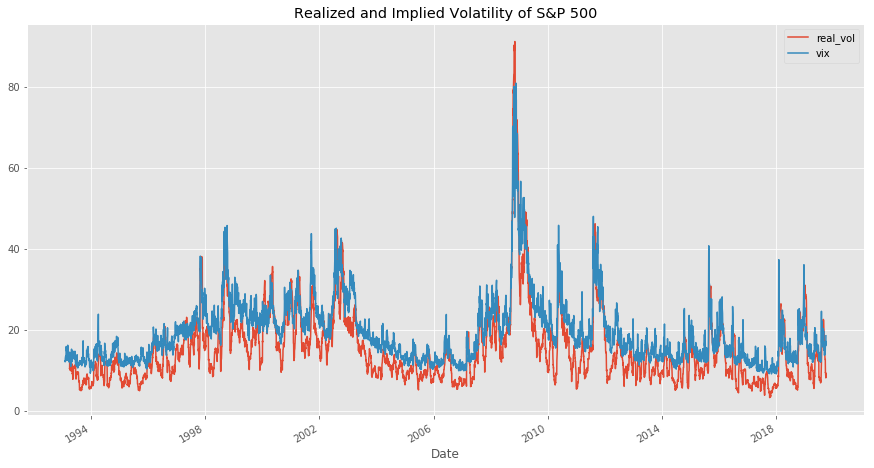

In [13]:
df['real_vol'].plot()
df['vix'].plot()
plt.legend()
plt.title('Realized and Implied Volatility of S&P 500')
plt.show()

# Building The Dataset

This loop will build the dataset by iterating through the Pandas dataframe:

In [14]:
VOL_THRESHOLD = 20
VOL_WINDOW = 10

In [15]:
records = []
spy_fifo = plumbing.FIFO(21)
vix_fifo = plumbing.FIFO(21)

lst = list(df.T.to_dict().items())[1:-VOL_WINDOW]

for n,(d,x) in enumerate(lst):
    spy_log = np.log(1 + x['spy_ret'])
    spy_buffer = spy_fifo.update(spy_log) 
    
    vix_log = np.log(1 + x['vix_ret'])
    vix_buffer = vix_fifo.update(vix_log)
    
    if np.isfinite(x['real_vol']):
        r.post_return(x['spy_ret'])
        fwd_vol = list(map(lambda i: i[1]['real_vol'], lst[n:n+VOL_WINDOW]))
        r.post_fwd_vol(fwd_vol)
        records += [r]

    r = Record(d, x['real_vol'], x['vix'], spy_buffer, vix_buffer)
    last = x

# Split In Two

When building a machine learning model, you should always split data into:

- a **training set**: used to develop your model, and  
- a **validation set**: also called "test set" used to validate the stablity of your model

This allows the ML algorithm to "learn" a model from the training set.  The performance of the model will then get validated on **unseen** validation data.

There are multiple ways to split the data. A common approach is to split the data into two sets.  As such, the datasets are also split into X and y values.  The convention in ML is to have:

$$ y = \beta \times X$$


We'll be using a classification algorithm to determine if the overnight return will be positive -- so the y value (target) will be:

0 -- if the realized volatility is less than our **VOL_THRESHOLD** within the next **VOL_WINDOW** days  
1 -- if the realized volatility is greater than our **VOL_THRESHOLD** at any time within the next **VOL_WINDOW** days




In [16]:
train, test  = train_test_split(records, shuffle=False, test_size=.5)

X_train = np.array(list(map(lambda r: r.get(), train[1:])))
y_train = np.array(list(map(lambda r: r.get_fwd_vol(VOL_THRESHOLD), train[1:])))

X_test = np.array(list(map(lambda r: r.get(), test[1:])))
y_test = np.array(list(map(lambda r: r.get_fwd_vol(VOL_THRESHOLD), test[1:])))

In [17]:
sum(y_train),len(y_train)

(936, 3331)

# Build a Model

![model](./img/4_model.png)

# Classification Models

Python's sklearn offers multiple classification models:

```Python
names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"]

from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
```

# Classification

Classification algorithms help predict if an outcome will be True or False.  A series of questions (**nodes**) lead to answers (**branches**) that ultimately lead to decisions (**leaves**).

A simple decision tree might try to predict if today will be a good day:

![simple treee](./img/simple_tree.png)

# How It Works

### Splitting
 Create nodes using available features.  
 Threshold the feature to maximize **Information Gain** (IG)  
 Add nodes up to the **maximum depth** allowed by the user  

### Pruning
 Remove branches from the tree that don't add significant information
 

### Information Gain

The information gain measures the reduction in entropy in $Y$ from the new information $X$.

$$IG(Y,X) = H_Y - H_{Y|X}$$

where:

$H_Y$  Entropy of $Y$  
$H_{Y|X}$ Entropy of $Y$ given $X$

### Entropy

$$H = \sum_{i=1}^N -p_i log_2(p_i)$$

where:

$p_i$ is the probability of observation $i$ being part of the $i$ class  

Entropy is a value between 0 and 1 where:

 0 --> is low  
 1 --> is high  

![entropy](./img/entropy.png)

[Provost, Foster; Fawcett, Tom. Data Science for Business: What You Need to Know about Data Mining and Data-Analytic Thinking](https://towardsdatascience.com/entropy-how-decision-trees-make-decisions-2946b9c18c8)

## Example -- Will the VIX $\gt$ 20?

Let's assume we are trying to predict if the implied volatility (or the VIX) will be higher than 20.  Let's use a single decision branch to figure this out by using the realized volatility as our decision branch.

### Measuring Entropy

Let's start by measuring the entropy of the VIX data at various thresholds of VIX values.  For this we'll sort the VIX values, calculate running probabilities of being above or below values as we iterate through the data.

In [18]:
VIX = sorted(df['vix'].tolist())
N = len(VIX)
N

6716

In [19]:
P = []
H = []
V_20 = None
for n,v in enumerate(VIX):
    p = float(n) / float(N)
    q = float(N-n) / float(N)
    h = -p * np.log2(p) - q * np.log2(q)
    if v > 20 and V_20 is None:
        V_20 = (p,h)
    P += [p]
    H += [h]
print('Probability VIX<20: %6.4f\nEntropy: %6.4f' % V_20)
print('Probability VIX>20: %6.4f' % (1- V_20[0]))

Probability VIX<20: 0.6312
Entropy: 0.9498
Probability VIX>20: 0.3688


/opt/local/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log2
  import sys
/opt/local/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in double_scalars
  import sys


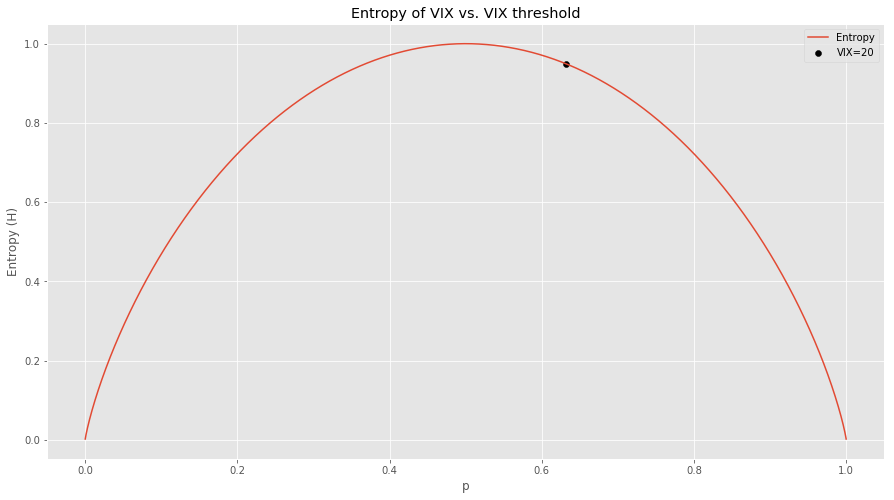

In [20]:
plt.plot(P,H,label='Entropy')
plt.title('Entropy of VIX vs. VIX threshold')
plt.scatter(*V_20,color='k', label='VIX=20')
plt.xlabel('p')
plt.ylabel('Entropy (H)')
plt.legend()
plt.show()

### Interpretation

A VIX threshold of 20 results in an entropy of 0.94.

### Using Realized Volatility

Now let's look at how realized volatility can help improve this number.

In [21]:
lst = df[['real_vol','vix']][42:].values.tolist()
lst = sorted(lst, key=lambda k: k[0])

In [22]:
H = []
n_gt_20 = 0
R = []
for n,(r,v) in enumerate(lst):
    if v > 20:
        n_gt_20 += 1
    if n>0 and n_gt_20 > 0:
        p = float(n_gt_20) / float(n)
        q = 1 - p
        h = -p * np.log2(p) - q * np.log2(q)
        R += [r]
        H += [h]
print('Average Entropy: %6.4f' % np.mean(H))

Average Entropy: 0.4061


### Interpretation

Good news!  The entropy of VIX $\gt$ 20 | Realized Volatility ($H_{VIX|Real Vol}$) is 0.4061.  This is substantially less than the entropy of VIX $\gt$ 20 = 0.9498.

We can compute the Information Gain as:

$$IG(VIX \gt 20, Real Vol) = H_{VIX \gt 20} - H_{VIX|Real Vol}$$

In [23]:
ig = V_20[1] - np.mean(H)
print('Information Gain : %6.4f' % ig)

Information Gain : 0.5436


## Model Assessment

To assess model quality Data Scientists and Business people use different metrics.  We'll use a mix of metrics:


### Confusion Matrix

This looks at the combinations of prediction vs actual to see how often a model predicts correctly given the True observation.  Some related metrics include:

#### Recall / Hit Rate (True Positive Rate)

$$TPR = \frac{TP}{TP + FN}$$

#### Precision (Positive Predicted Value)

$$PPV = \frac{TP}{TP+FP}$$

#### Miss Rate (Negative Predicted Value)

$$NPV = \frac{FN}{FN+TP}$$

#### Accuracy

$$ACC = \frac{TP + TN}{P + N}$$

### ROC Curve

This plot along with the AUC provides an idea of the "quality" of the model and it's ability to classify correctly.  The closer the AUC to 1.0, the better the model.

### Business Metrics

In our case, we will use the performance (p&l) and volatility of a trading strategy that trades our model vs. the pnl of a buy and hold strategy.

# Gradient Boosting Classifier

This classifier has become quite popular over recent years since it offers good performance both in and out of sample.

In [24]:
from sklearn.ensemble import GradientBoostingClassifier
params = {'subsample':.5, 'n_estimators':10,
         'max_depth':2, 'min_samples_split': 5, 
          'max_features':2}
clf = GradientBoostingClassifier(**params)
f = clf.fit(X_train, y_train)

/opt/local/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


### In Sample Performance

Confusion Matrix
Raw
[[2369   26]
 [ 257  679]]
Normalized
[[0.71119784 0.00780546]
 [0.07715401 0.20384269]]
Accuracy: 0.9150405283698589


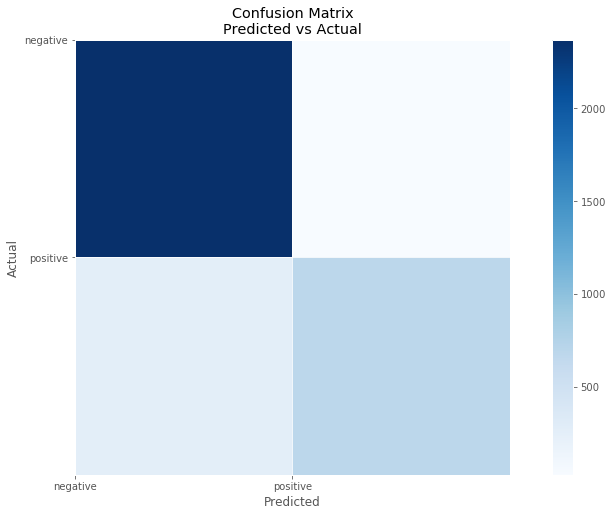

In [25]:
Y_hat = clf.predict(X_train)
r = util.cf_matrix(y_train, Y_hat)
acc = (r[0][0] + r[1][1]) / np.sum(r)
print('Accuracy:', acc)

### Out of Sample Performance

Confusion Matrix
Raw
[[2448   46]
 [ 210  628]]
Normalized
[[0.73469388 0.01380552]
 [0.06302521 0.18847539]]
Accuracy: 0.9231692677070829


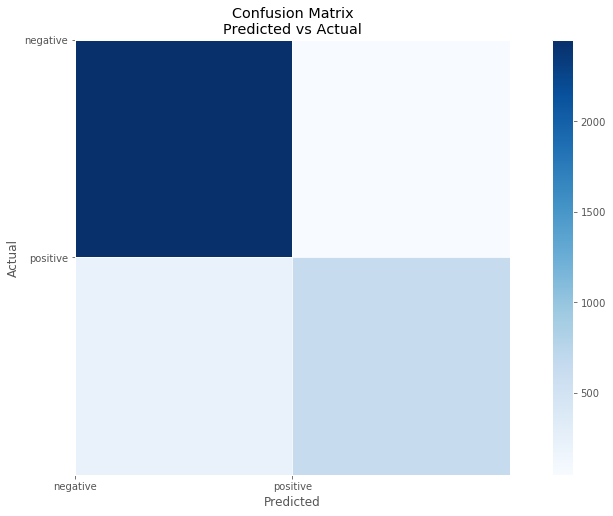

In [26]:
Y_hat = clf.predict(X_test)
r = util.cf_matrix(y_test, Y_hat)
acc = (r[0][0] + r[1][1]) / np.sum(r)
print('Accuracy:', acc)

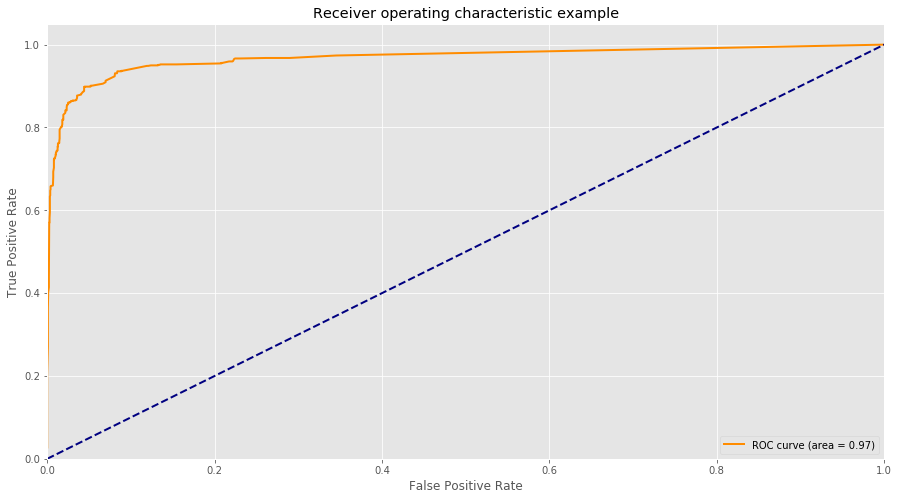

In [27]:
util.plot_auc(clf, X_train, y_train, X_test,y_test)

### Business Metrics

Let's look at the P&L performance.

--------------------
Strategy (in sample)
--------------------
+--------+------------------------+
| metric |         value          |
+--------+------------------------+
|  mean  | 0.00013699547994712157 |
| st_dev |  0.007607325947199496  |
| Sharpe |  0.28587388514366335   |
+--------+------------------------+
------------------------
Buy And Hold (in sample)
------------------------
+--------+-----------------------+
| metric |         value         |
+--------+-----------------------+
|  mean  | 0.0004310038909218351 |
| st_dev |  0.010888437632217628 |
| Sharpe |   0.6283706522446985  |
+--------+-----------------------+
------------------------
Strategy (out of sample)
------------------------
+--------+----------------------+
| metric |        value         |
+--------+----------------------+
|  mean  | 0.000286592244152203 |
| st_dev | 0.007185436186249286 |
| Sharpe |  0.6331572247410909  |
+--------+----------------------+
----------------------------
Buy And Hold (out of sa

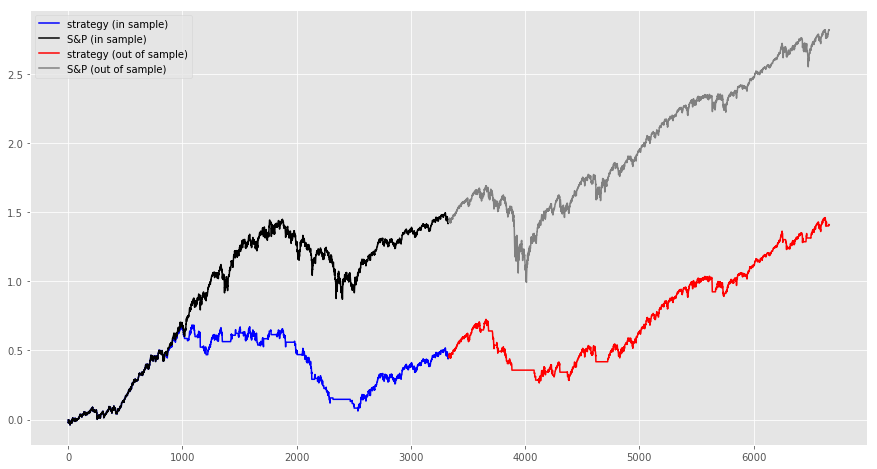

In [28]:
pnl = util.get_pnl_plot(clf, train[1:], test[1:])

### Explainability

Machine Learning models are often critized for their lack of explainability.  The decision trees are complex and difficult to interpret.  It is fairly straightforward to examine.

In [29]:
r = records[0]
v = sorted(list(zip(r.header,f.feature_importances_)), key=lambda k:k[1],reverse=True)
v

[('real_vol', 0.3363665415246601),
 ('vix_min', 0.20865913272264075),
 ('spy_max', 0.13757003288684697),
 ('spy_min', 0.10037969818273185),
 ('vix_max', 0.08245448526377067),
 ('vix', 0.07367025120254504),
 ('spy_mean', 0.04095248529872768),
 ('spy_minus_1', 0.01567891254665095),
 ('vix_mean', 0.004268460371425946),
 ('spy_minus_2', 0.0),
 ('vix_minus_1', 0.0),
 ('vix_minus_2', 0.0)]

#### Nodes

Each node in the tree can be displayed, but the visualization is quite difficult.

[sample visualization](https://arogozhnikov.github.io/2016/06/24/gradient_boosting_explained.html)

In [30]:
len(clf.estimators_)

10

In [31]:
clf.estimators_

array([[DecisionTreeRegressor(criterion='friedman_mse', max_depth=2, max_features=2,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=5, min_weight_fraction_leaf=0.0,
           presort='auto',
           random_state=<mtrand.RandomState object at 0x10d358b90>,
           splitter='best')],
       [DecisionTreeRegressor(criterion='friedman_mse', max_depth=2, max_features=2,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=5, min_weight_fraction_leaf=0.0,
           presort='auto',
           random_state=<mtrand.RandomState object at 0x10d358b90>,
           splitter='best')],
       [DecisionTreeRegressor(criterion='friedman_mse', max_depth=2, max_features=2,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_spl

# Conclusion

![model](./img/5_conclusion.png)

### Data Science Metrics

The AUC is very high at 0.97 and both the in-sample and out-of-sample accuracy are high (and stable) at ~92%.

### Business Metrics

The model seems to predict volatility very accurately and manages to achieve much better 




In [33]:
(N, spx, pnl) = util.get_pnl_data(clf, train[1:])
result = {'Strategy (in)': util.get_metrics(pnl, 'strategy (in)', False),
           'SPX (in)': util.get_metrics(spx, 'SPX (in)', False),
          }
(N, spx, pnl) = util.get_pnl_data(clf, test[1:])
result['Strategy (Out)'] = util.get_metrics(pnl, 'Strategy (Out)', False)
result['SPX (out)'] = util.get_metrics(spx, 'SPX (out)', False)


print('\nANNUALIZED RETURNS\n')

metrics = ['mean','st_dev']
pt = prettytable.PrettyTable(['strategy'] + metrics)
for (label, mm) in result.items():
    tail = [ np.exp(mm['mean'] * 252) - 1.0, mm['st_dev'] * 252 **.5 ]
    r = [label] + list(map(lambda m: '%6.4f' % m, tail)) 

    pt.add_row(r)
print(pt)


ANNUALIZED RETURNS

+----------------+--------+--------+
|    strategy    |  mean  | st_dev |
+----------------+--------+--------+
| Strategy (in)  | 0.0351 | 0.1208 |
|    SPX (in)    | 0.1147 | 0.1728 |
| Strategy (Out) | 0.0749 | 0.1141 |
|   SPX (out)    | 0.1105 | 0.1914 |
+----------------+--------+--------+


### Conclusion

The model achieves its goal of predicting volatility within the ```VOL_WINDOW```.  The annual returns performance of the strategy is not as good as the buy and hold SPY strategy, but the volatility is ~30% less. 

# Questions Managers Should be Asking

What are your data sources?  How did you prepare the data?

What features are you using?  Which ones are most useful?

What is your in-sample / out-of-sample split?
 - 50/50 is good
 - rolling window may be good
 - did you burn your out of sample data (i.e. how often did you reject your model after looking at the out of sample performance)?

What type of model did you run?
 - Regression?
 - Classification?
 - Neural Net?
 - Unsupervised learning?

What is the AUC of the model?  
How stable is the confusion matrix between in and out of sample?  
How closely related are the business metrics to the data science metrics?
Boil it down to business metrics?
 - ROI
 - Confidence interval? / Risk?

# Further Reading

[Gradient Boosting Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html)

[Nice Explanation](https://stackabuse.com/gradient-boosting-classifiers-in-python-with-scikit-learn/)


$$IQ = e^{.2 \Delta T}$$